In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
device = torch.device("cuda")
print(device)

cuda


In [0]:
def img_to_tensor(image, loader):
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/'

content_img = Image.open(path + 'cat.jpg')
style_img = Image.open(path + 'stary.jpg')

img_size = content_img.size
loader = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

content_img = img_to_tensor(content_img, loader)
style_img = img_to_tensor(style_img, loader)

In [0]:
def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = transforms.ToPILImage()(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

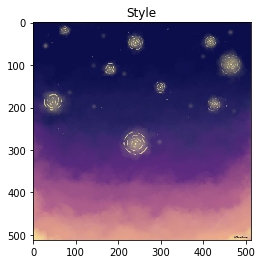

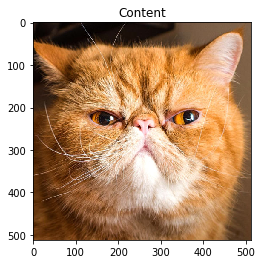

In [9]:
plt.figure()
imshow(style_img, 'Style')

plt.figure()
imshow(content_img, 'Content')

In [0]:
class ContentLoss(nn.Module):
  
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [0]:
class StyleLoss(nn.Module):
  
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()
  
  @staticmethod
  def gram_matrix(input):
    batch, channels, h, w = input.size()
    features = input.view(batch * channels, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch * channels * h * w)
  
  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [0]:
class Normalization(nn.Module):
  def __init__(self, dtype):
    super(Normalization, self).__init__()
    self.mean = torch.Tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).type(dtype)
    self.std = torch.Tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).type(dtype)
  
  def forward(self, img):
    out = (img - self.mean) / self.std
    return out

In [0]:
def build_network(cnn, style_img, content_img, content_layers, style_layers):
  cnn = copy.deepcopy(cnn)
  
  normalization = Normalization(style_img.type()).to(device)
  
  content_losses = []
  style_losses = []
  
  model = nn.Sequential(normalization)
  
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer:{}'.format(layer.__class__.__name__))
      
    model.add_module(name, layer)
      
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
        
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
        
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]
  
  return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
def run_style_transfer(cnn, content_img, style_img, input_img, content_layer, style_layers, num_steps=100, style_weight=1000000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = build_network(
      cnn, style_img, content_img,content_layer, style_layers
  )
  optimizer = get_input_optimizer(input_img)
  
  print('Optimizing..')
  run = 0
  while run <= num_steps:
    
    def closure():
      input_img.data.clamp_(0, 1)
      
      optimizer.zero_grad()
      
      model(input_img)
      style_score = 0
      content_score = 0
      
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
        
      style_score *= style_weight
      content_score *= content_weight
      
      loss = style_score + content_score
      loss.backward()
      return style_score + content_score
    
    optimizer.step(closure)
    run = run + 1
    if run % 10 == 0:
      print('Step:', run)
  input_img.data.clamp_(0, 1)
  
  return input_img

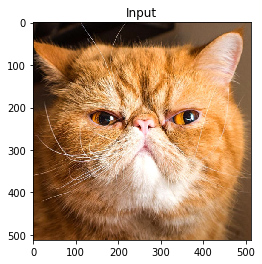

In [37]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, 'Input')

In [38]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layer = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

output = run_style_transfer(
    cnn, content_img, style_img, input_img, content_layer, style_layers
)

Building the style transfer model..
Optimizing..
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100


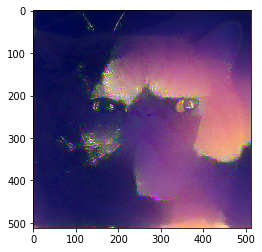

In [39]:
imshow(output)